#Clone Portal users, groups and content

This sample notebook can be used for cloning an entire Portal, from maybe a staging to a production environment. It clones the users, groups and the content. It does not copy over services and data though, and works at the tier of Portal items.

To start with, define the source and target portals:

In [1]:
source = GIS("https://dev04875.esri.com/arcgis", "portaladmin", "portaladmin")
target = GIS("https://dev06999.esri.com/portal", "admin", "changeit")

#Users
List the users in the source and target portals:

In [2]:
sourceusers = source.users.list()
sourceusers

[<User username:admin>,
 <User username:esri_nav>,
 <User username:olearydw_uc2015>,
 <User username:portaladmin>,
 <User username:portaladmin2>,
 <User username:system_publisher>,
 <User username:test2>,
 <User username:userFive>,
 <User username:userFour>,
 <User username:userOne>,
 <User username:userSeven>,
 <User username:userSix>,
 <User username:userThree>,
 <User username:userTwo>]

In [3]:
targetusers = target.users.list()
targetusers

[<User username:admin>,
 <User username:esri_nav>,
 <User username:olearydw_uc2015>,
 <User username:portaladmin>,
 <User username:portaladmin2>,
 <User username:system_publisher>,
 <User username:test2>,
 <User username:userFive>,
 <User username:userFour>,
 <User username:userOne>,
 <User username:userSeven>,
 <User username:userSix>,
 <User username:userThree>,
 <User username:userTwo>]

If source users are already in the target, run the following code to delete them:

In [4]:
for srcuser in sourceusers:
    targetusr = target.users.get(srcuser.username)
    if targetusr is not None and targetusr.username != 'admin':
        targetusr.reassign_to('admin')
        targetusr.delete()

##Copy Users

In [5]:
def copy_user(target, user, password):
    # See if the user has firstName and lastName properties
    try:
        firstname = user.firstName
        lastname = user.lastName
    except:
        # if not, split the fullName
        fullName = user.fullName
        firstname = fullName.split()[0]
        try:
            lastname = fullName.split()[1]
        except:
            lastname = 'NoLastName'

    try:
        # create user
        target_user = target.users.create(user.username, password, firstname, lastname,
                                          user.email, user.description)

        # update user properties
        target_user.update(user.access, user.preferredView,
                           user.description, user.tags, user.get_thumbnail_link(),
                           culture=user.culture, region=user.region)

        # update user role
        if 'role' in user and not user.role == 'org_user':
            target_user.update_role(user.role)

        return target_user
    
    except:
        print("Unable to create user "+ user.username)
        return None

For each user in source portal, make a corresponding user in target portal:

In [6]:
for user in sourceusers:
    copy_user(target, user, 'TestPassword@123')

ERROR:arcgis._impl.portalpy:java.lang.Exception: The server at 'https://DEV06999.ESRI.COM:7443/arcgis/sharing/rest/community/createUser' returned an error. The user already exists.  Please check the username and try again. []


Unable to create user admin


Verify that users have been added to target portal:

In [7]:
targetusers = target.users.list()
targetusers

[<User username:admin>,
 <User username:esri_nav>,
 <User username:olearydw_uc2015>,
 <User username:portaladmin>,
 <User username:portaladmin2>,
 <User username:system_publisher>,
 <User username:test2>,
 <User username:userFive>,
 <User username:userFour>,
 <User username:userOne>,
 <User username:userSeven>,
 <User username:userSix>,
 <User username:userThree>,
 <User username:userTwo>]

#Groups

List the groups in the source and target portals:

In [8]:
sourcegroups = source.groups.list()
sourcegroups

[<Group title:"Basemaps" owner:portaladmin>,
 <Group title:"Central Services" owner:portaladmin>,
 <Group title:"Compliance" owner:portaladmin>,
 <Group title:"Customer Service, Finance, Billing and Accounting" owner:portaladmin>,
 <Group title:"Demographic Content" owner:portaladmin>,
 <Group title:"Design and Engineering" owner:portaladmin>,
 <Group title:"Disaster Response" owner:portaladmin>,
 <Group title:"Executive Reports" owner:portaladmin>,
 <Group title:"External Contractors" owner:portaladmin>,
 <Group title:"Featured Apps" owner:portaladmin>,
 <Group title:"Field and Facility Maintenance" owner:portaladmin>,
 <Group title:"Fire Service" owner:portaladmin>,
 <Group title:"Gallery" owner:portaladmin>,
 <Group title:"Industrial Monitoring" owner:portaladmin>,
 <Group title:"Lab Services" owner:portaladmin>,
 <Group title:"Land Use Content" owner:portaladmin>,
 <Group title:"Network Operations" owner:portaladmin>,
 <Group title:"Public Maps and Apps" owner:portaladmin>,
 <Group

In [9]:
targetgroups = target.groups.list()
targetgroups

[<Group title:"Basemaps" owner:admin>,
 <Group title:"Central Services" owner:admin>,
 <Group title:"Compliance" owner:admin>,
 <Group title:"Customer Service, Finance, Billing and Accounting" owner:admin>,
 <Group title:"Demographic Content" owner:admin>,
 <Group title:"Design and Engineering" owner:admin>,
 <Group title:"Disaster Response" owner:admin>,
 <Group title:"Executive Reports" owner:admin>,
 <Group title:"External Contractors" owner:admin>,
 <Group title:"Featured Apps" owner:admin>,
 <Group title:"Field and Facility Maintenance" owner:admin>,
 <Group title:"Fire Service" owner:admin>,
 <Group title:"Gallery" owner:admin>,
 <Group title:"Industrial Monitoring" owner:admin>,
 <Group title:"Lab Services" owner:admin>,
 <Group title:"Land Use Content" owner:admin>,
 <Group title:"Network Operations" owner:admin>,
 <Group title:"Public Maps and Apps" owner:admin>,
 <Group title:"Tools and Add-Ins" owner:admin>,
 <Group title:"Wastewater Treatment" owner:admin>,
 <Group title:"W

If source groups are already in the target, run the following code to delete them:

In [10]:
for tg in targetgroups:
    for sg in sourcegroups:
        if sg.title == tg.title:
            tg.delete()
            break

##Copy Groups

In [11]:
GROUP_COPY_PROPERTIES = ['title', 'description', 'tags', 'snippet', 'phone',
                         'access', 'isInvitationOnly']

def copy_group(target, source, group):
    """ Copy group to the target portal."""
    with tempfile.TemporaryDirectory() as temp_dir:
        # Create a new groups with the subset of properties we want to
        # copy to the target portal. Handle switching between org and
        # public access when going from an org in a multitenant portal
        # and a single tenant portal
        target_group = {}
        
        for property_name in GROUP_COPY_PROPERTIES:
            target_group[property_name] = group[property_name]

        if target_group['access'] == 'org' and target.properties['portalMode'] == 'singletenant':
            target_group['access'] = 'public'
        elif target_group['access'] == 'public'\
             and source.properties['portalMode'] == 'singletenant'\
             and target.properties['portalMode'] == 'multitenant'\
             and 'id' in target.properties: # is org
            target_group['access'] = 'org'

        # Handle the thumbnail (if one exists)
        thumbnail_file = None
        if 'thumbnail' in group:
            target_group['thumbnail'] = group.download_thumbnail(temp_dir)

        # Create the group in the target portal
        copied_group = target.groups.create_from_dict(target_group)
        
         # Reassign all groups to correct owners, add users, and find shared items
        members = group.get_members()
        copied_group.reassign_to(members['owner'])
        if members['users']:
            copied_group.add_users(members['users'])
        return copied_group

For each group in source portal, make a sorresponding group in target portal:

In [12]:
copied_groups = {}
for group in sourcegroups:
    tgt_group = copy_group(target, source, group)
    copied_groups[group.groupid] = tgt_group.groupid

30f24527dec64136a8eef82e893ff895
e49dacf9ac1b499594fadace6470baa3
450829a4cb0646eab688f77ad2a80831
02d2ba4ce531419f95e7271cad308681
a4fb663c786e4223b3f80d196661746c
c0a4ad6824d24cd7a1a3b279660ea49e
11e0e722cf1f4b89b9f4fb2dff2fb3cd
921eea01ba264c77b6fe4d1afcf921c1
73bb76065fa44b1597750b8d10243e33
1cfbe7174546414e99f715a2bb46a2a0
c62b5a0c39194b3c96a7725d9234710a
0b6a1f5006924b859d0f03b2a8951087
011c53594fde45c0966048aabdbd5ec6
ea5045a2a50a449daadad1095996245b
1771ff8adaba4bb299d50dc8a6567e01
03483d8c3d3145e1a38708ffee1d3a23
01f0edee32064e8d979ec7ab2a8a243a
ed86659866f74c06be7bfa80dbef0d3e
c674ee77b1cd493697c8159d17a51138
baf01f49e4d245cb98decd4c45b98634
56d7c5172f8948619195c4940236c995
6ecc3ff67917425b9a6e4580fb6cdc68


Verify that groups have been created in the target portal:

In [13]:
targetgroups = target.groups.list()
targetgroups

[<Group title:"Basemaps" owner:portaladmin>,
 <Group title:"Central Services" owner:portaladmin>,
 <Group title:"Compliance" owner:portaladmin>,
 <Group title:"Customer Service, Finance, Billing and Accounting" owner:portaladmin>,
 <Group title:"Demographic Content" owner:portaladmin>,
 <Group title:"Design and Engineering" owner:portaladmin>,
 <Group title:"Disaster Response" owner:portaladmin>,
 <Group title:"Executive Reports" owner:portaladmin>,
 <Group title:"External Contractors" owner:portaladmin>,
 <Group title:"Featured Apps" owner:portaladmin>,
 <Group title:"Field and Facility Maintenance" owner:portaladmin>,
 <Group title:"Fire Service" owner:portaladmin>,
 <Group title:"Gallery" owner:portaladmin>,
 <Group title:"Industrial Monitoring" owner:portaladmin>,
 <Group title:"Lab Services" owner:portaladmin>,
 <Group title:"Land Use Content" owner:portaladmin>,
 <Group title:"Network Operations" owner:portaladmin>,
 <Group title:"Public Maps and Apps" owner:portaladmin>,
 <Group

#Items

Deduce the groups that each copied item will belong to:

In [14]:
source_items_by_id = {}
for user in sourceusers:
    usercontent = user.content()
    folders = usercontent.keys()
    for folder in folders:
        folderitems = usercontent[folder]
        for item in folderitems:
            source_items_by_id[item.itemid] = item     

In [15]:
for group in sourcegroups:
    target_group_id = copied_groups[group.groupid]
    for group_item in group.content():
        item = source_items_by_id[group_item.itemid]
        if item is not None:
            if not 'groups'in item:
                item['groups'] = []
            item['groups'].append(target_group_id)
        else:
            print("Not found item : " + group_item.itemid)

In [16]:
for key in source_items_by_id.keys():
    item = source_items_by_id[key]
    print("******\n"+item.title)
    if 'groups' in item:
        print(item.access)
        print(item.groups)

******
SanDiego_StreetAddress
******
RAILROAD
******
Cool_Zones
public
['30f24527dec64136a8eef82e893ff895', 'e49dacf9ac1b499594fadace6470baa3', '450829a4cb0646eab688f77ad2a80831', '02d2ba4ce531419f95e7271cad308681']
******
County_Boundary
public
['30f24527dec64136a8eef82e893ff895', 'e49dacf9ac1b499594fadace6470baa3', '450829a4cb0646eab688f77ad2a80831']
******
SampleWorldCities
******
Roads
******
Water_Network
******
testWebMap app
******
RAILROAD
******
EsriAddress
******
Geometry
public
['30f24527dec64136a8eef82e893ff895', 'e49dacf9ac1b499594fadace6470baa3', '450829a4cb0646eab688f77ad2a80831']
******
Businesses_Small
public
['30f24527dec64136a8eef82e893ff895', 'e49dacf9ac1b499594fadace6470baa3', '450829a4cb0646eab688f77ad2a80831']
******
World
public
['02d2ba4ce531419f95e7271cad308681']
******
Summarize_Businesses_Small_in_Businesses_Small
******
SDWebMap
public
['02d2ba4ce531419f95e7271cad308681']
******
Sample
******
PrintingTools
******
Parks_SHP
public
['02d2ba4ce531419f95e7271ca

##Copy Items

In [17]:
TEXT_BASED_ITEM_TYPES = frozenset(['Web Map', 'Feature Service', 'Map Service',
                                   'Image Service', 'Feature Collection', 'Feature Collection Template',
                                   'Web Mapping Application', 'Mobile Application', 'Symbol Set', 'Color Set',
                                   'Windows Viewer Configuration'])
ITEM_COPY_PROPERTIES = ['title', 'type', 'typeKeywords', 'description', 'tags',
                        'snippet', 'extent', 'spatialReference', 'name',
                        'accessInformation', 'licenseInfo', 'culture', 'url', ]

def copy_item(target, owner, folder, item):
    with tempfile.TemporaryDirectory() as temp_dir:
        copy_item = {}
        for property_name in ITEM_COPY_PROPERTIES:
            copy_item[property_name] = item[property_name]

        data_file = None
        if item.type in TEXT_BASED_ITEM_TYPES:
            # If its a text-based item, then read the text and add it to the request.
            if item.size > 0:
                text = item.get_data(False)
                textstr = text.decode('utf-8')
                copy_item['text'] = textstr
        elif item.size > 0: # download data for all other types, not just item.type in FILE_BASED_ITEM_TYPES:
            # download data and add to the request as a file
            data_file = item.download(temp_dir)

        thumbnail_file = item.download_thumbnail(temp_dir)

        metadata_file = item.download_metadata(temp_dir)

        # Add the item to the target portal
        copied_item = target.content.add(copy_item, data_file, thumbnail_file, metadata_file, owner, folder)

        return copied_item

In [18]:
RELATIONSHIP_TYPES = frozenset(['Map2Service', 'WMA2Code',
                                'Map2FeatureCollection', 'MobileApp2Code', 'Service2Data',
                                'Service2Service'])

def copy_relationships(target, copied_items, src_item, relationships, owner, folder):
    
    target_item_id = copied_items.get(src_item.itemid)
    if target_item_id is not None:
        target_item = target.content.get(target_item_id)

        for rel_type in RELATIONSHIP_TYPES:
            src_rel_items = src_item.related_items(rel_type)

            for src_rel_item in src_rel_items:
                print("***Found related items for " + src_rel_item.title)
                source_rel_id = src_rel_item.itemid

                # See if it's already been copied to the target
                target_rel_id = copied_items.get(source_rel_id)
                if not target_rel_id:
                    # If not, then copy it to the target - folder may have moved though?
                    target_rel_item = clone_item(target, owner, folder, src_rel_item)

                    if target_rel_item is not None:
                        # add relationship from target_item to copied item
                        result = target_item.add_relationship(target_rel_item, rel_type)

                        if not result:
                            print('Unable to add relationship from ' +  target_item.itemid + ' to ' + target_rel_item.itemid)
                    else:
                        print("@@@Error Cloning Item "+src_rel_item.title)

**************
admin
/
**************
esri_nav
/
**************
olearydw_uc2015
/


<Item title:"DM - Road Ahead Demo" type:Web Mapping Application owner:olearydw_uc2015>

<Item title:"DM - Road Ahead Demo" type:Web Mapping Application owner:olearydw_uc2015>
**************
portaladmin
/


<Item title:"PrintingTools" type:Geoprocessing Service owner:portaladmin>

<Item title:"PrintingTools" type:Geoprocessing Service owner:portaladmin>


<Item title:"SampleWorldCities" type:Map Service owner:portaladmin>

<Item title:"SampleWorldCities" type:Map Service owner:portaladmin>


<Item title:"World" type:Geocoding Service owner:portaladmin>

<Item title:"World" type:Geocoding Service owner:portaladmin>


<Item title:"Roads" type:Service Definition owner:portaladmin>
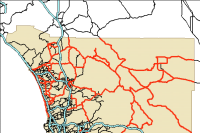

<Item title:"Roads" type:Service Definition owner:portaladmin>


<Item title:"testWebMap app" type:Web Mapping Application owner:portaladmin>
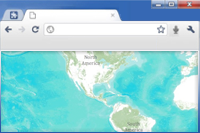

<Item title:"testWebMap app" type:Web Mapping Application owner:portaladmin>


<Item title:"SanDiego_StreetAddress" type:Geocoding Service owner:portaladmin>

<Item title:"SanDiego_StreetAddress" type:Geocoding Service owner:portaladmin>


<Item title:"County_Boundary" type:Shapefile owner:portaladmin>

<Item title:"County_Boundary" type:Shapefile owner:portaladmin>


<Item title:"NewFeatureLayer1" type:Feature Service owner:portaladmin>
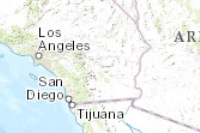

<Item title:"NewFeatureLayer1" type:Feature Service owner:portaladmin>


<Item title:"Businesses_Small" type:Feature Service owner:portaladmin>
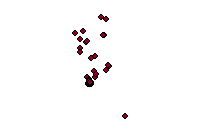

<Item title:"Businesses_Small" type:Feature Service owner:portaladmin>


<Item title:"SDWebMap" type:Web Map owner:portaladmin>

<Item title:"SDWebMap" type:Web Map owner:portaladmin>


<Item title:"World Cities" type:Web Map owner:portaladmin>
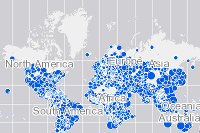

<Item title:"World Cities" type:Web Map owner:portaladmin>


<Item title:"Geometry" type:Geometry Service owner:portaladmin>

<Item title:"Geometry" type:Geometry Service owner:portaladmin>


<Item title:"Parks_SHP" type:Feature Service owner:portaladmin>
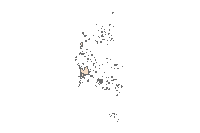

<Item title:"Parks_SHP" type:Feature Service owner:portaladmin>


<Item title:"Cool_Zones" type:CSV owner:portaladmin>
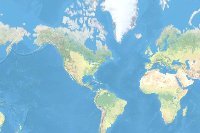

<Item title:"Cool_Zones" type:CSV owner:portaladmin>


<Item title:"Parks_SHP" type:Shapefile owner:portaladmin>

<Item title:"Parks_SHP" type:Shapefile owner:portaladmin>


<Item title:"RAILROAD" type:Feature Service owner:portaladmin>
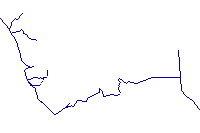

<Item title:"RAILROAD" type:Feature Service owner:portaladmin>


<Item title:"RAILROAD" type:Shapefile owner:portaladmin>

<Item title:"RAILROAD" type:Shapefile owner:portaladmin>


<Item title:"Water_Network" type:Map Service owner:portaladmin>
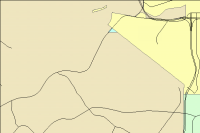

<Item title:"Water_Network" type:Map Service owner:portaladmin>


<Item title:"County_Boundary" type:Feature Service owner:portaladmin>
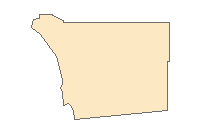

<Item title:"County_Boundary" type:Feature Service owner:portaladmin>


<Item title:"Sample" type:Web Map owner:portaladmin>
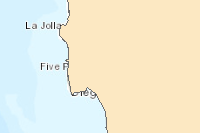

ERROR:arcgis._impl.portalpy:A JSONObject text must begin with '{' at character 0 of 
ERROR:arcgis._impl.portalpy:A JSONObject text must begin with '{' at character 0 of 


<Item title:"Sample" type:Web Map owner:portaladmin>
Error copying Sample


<Item title:"Roads" type:Map Service owner:portaladmin>
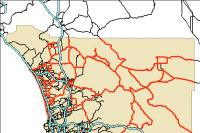

<Item title:"Roads" type:Map Service owner:portaladmin>
WebMaps


<Item title:"EsriAddress" type:Web Map owner:portaladmin>
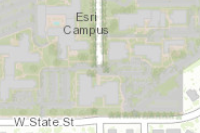

<Item title:"EsriAddress" type:Web Map owner:portaladmin>


<Item title:"SanDiegoCoolZones1" type:Web Map owner:portaladmin>
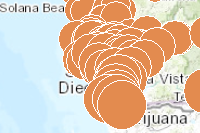

<Item title:"SanDiegoCoolZones1" type:Web Map owner:portaladmin>


<Item title:"BusinessPlusWaterNetworks" type:Web Map owner:portaladmin>
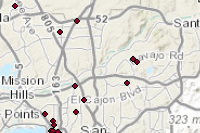

<Item title:"BusinessPlusWaterNetworks" type:Web Map owner:portaladmin>


<Item title:"SanDiegoZooUsingCustomGeocoder1" type:Web Map owner:portaladmin>
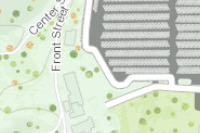

<Item title:"SanDiegoZooUsingCustomGeocoder1" type:Web Map owner:portaladmin>


<Item title:"Water_Network" type:Service Definition owner:portaladmin>
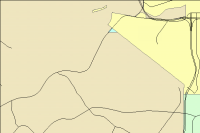

<Item title:"Water_Network" type:Service Definition owner:portaladmin>


<Item title:"Summarize_Businesses_Small_in_Businesses_Small" type:Feature Service owner:portaladmin>
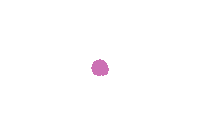

<Item title:"Summarize_Businesses_Small_in_Businesses_Small" type:Feature Service owner:portaladmin>
***Found related items for Parks_SHP
***Found related items for RAILROAD
***Found related items for Water_Network
***Found related items for County_Boundary
***Found related items for Roads
**************
portaladmin2
/
**************
system_publisher
/
**************
test2
/
**************
userFive
/
**************
userFour
/
**************
userOne
/
**************
userSeven
/
**************
userSix
/
**************
userThree
/
**************
userTwo
/


In [19]:
copied_items = {}
relationships = RELATIONSHIP_TYPES

for user in sourceusers:
    print("**************\n"+user.username)
    usercontent = user.content()
    folders = usercontent.keys()
    
    for folder in folders:
        print(folder)
        target.content.create_folder(user, folder)
        folderitems = usercontent[folder]
        for item in folderitems:
            display(item)
            print(item.__repr__())
            copied_item = copy_item(target, user, folder, item)
            if copied_item is not None:
                copied_items[item.itemid] = copied_item.itemid
                
                # share the item
                copied_item.share(item.access == 'public',
                                  item.access in ['org', 'public'],
                                  source_items_by_id[item.itemid].groups 
                                      if 'groups' in source_items_by_id[item.itemid]
                                      else None)
            else:
                print('Error copying ' + item.title)
            
    # Copy the related items for this user (if specified)
    if relationships:
        for folder in folders:
            folderitems = usercontent[folder]
            for item in folderitems:
                copy_relationships(target, copied_items, item, relationships, user, folder)
